In [1]:
 %matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import desc

In [5]:
Base = automap_base()
engine = create_engine("sqlite:///Resources/hawaii.sqlite", connect_args={'check_same_thread': False})

In [6]:
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)
# reflect the tables
Station=Base.classes.station
Measurement=Base.classes.measurement

In [7]:
# We can view all of the classes that automap found
session = Session(engine)


In [8]:
# Save references to each table


In [9]:
date = session.query(Measurement.date).order_by(desc(Measurement.date)).first()[0]
prev_year = dt.datetime.strptime(date , '%Y-%m-%d') - dt.timedelta(days=365)

Text(0, 0.5, 'Inches')

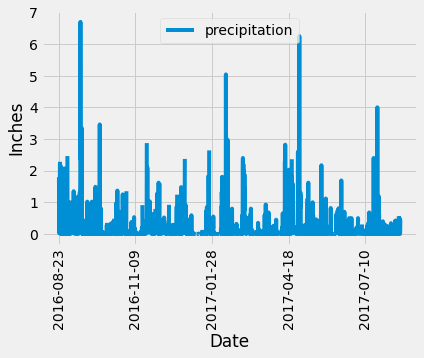

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Starting from the last data point in the database 

# Calculate the date 1 year ago from the last data point in the database
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
df = df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='date', y='precipitation', rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
    

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

Text(9.310000000000002, 0.5, 'Frequency')

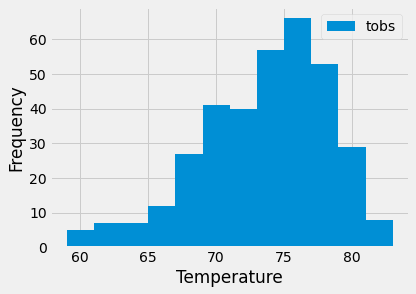

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
import datetime as dt
from pandas.plotting import table
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= prev_year).all()
df = pd.DataFrame(results, columns=['tobs'])
df.plot.hist(bins=12)
plt.tight_layout()
plt.xlabel("Temperature")
plt.ylabel("Frequency")


In [16]:
session.close()

In [ ]:
# Create our session (link) from Python to the DB
# Flask routes
import datetime as dt

import numpy as np
import pandas as pd

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

from flask import Flask, jsonify


# Database Setup
engine = create_engine("sqlite:///Resources/hawaii.sqlite",connect_args={'check_same_thread': False} )

# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)


# FLASK SETUP

app = Flask(__name__)



# FLASK ROUTES


@app.route("/")
def welcome():
    return (
        f"Welcome to the Hawaii Climate Analysis API!<br/>"
        f"Available Routes:<br/>"
        f"api/v1.0/precipitation<br/>"
        f"api/v1.0/stations<br/>"
        f"api/v1.0/tobs<br/>"
        f"api/v1.0/temp/start/end"
    )

@app.route("/api/v1.0/precipitation")
def precipitation():
    """Return the precipitation data for the last year"""
    # Calculate the date 1 year ago from the last data point in the database
    prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
    
    # Perform a query to retrieve the data and precipitation scores
    precipitation = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year)
               
    # Dict with date as the key and prcp as the value
    precip = {date: prcp for date, prcp in precipitation}
    return jsonify(precip)

@app.route("/api/v1.0/stations")
def stations():
    """Return a list of stations"""
    results = session.query(Station.station).all()
               
# Unravel results into a 1D array and convert to a list
    stations = list(np.ravel(results))
    return jsonify(stations=stations)
               
               

@app.route("/api/v1.0/tobs")
def temp_monthly():
    """Return the temperature observations (tobs) for previous year"""
# Calculate the date 1 year ago from last date in database
    prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
               
# Query the primary station for all tobs from the last year
    results = session.query(Measurement.tobs).\
        filter(Measurement.station == 'USC00519281').\
        filter(Measurement.date >= prev_year).all()
               
# Unravel results into a 1D array and convert to a list
    temps = list(np.ravel(results))
               
# Return the results
    return jsonify(temps=temps)
               

               
@app.route("/api/v1.0/temp/<start>")
@app.route("/api/v1.0/temp/<start>/<end>")
def stats(start=None, end=None):
    """Return TMIN, TAVG, TMAX"""
    if start is not None:
        formatdatestart=dt.datetime.strptime(start, "%m%d%Y")             
    if end is not None:
        formatdateend=dt.datetime.strptime(end, "%m%d%Y")
# Select statement
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    
    if not end:
# calculate TMIN, TAVG, TMAX for dates greater than start
        results = session.query(*sel).\
            filter(Measurement.date >= formatdatestart).all()
# Unravel results into a 1D array and convert to a list
        temps = list(np.ravel(results))
        return jsonify(temps)
               
     # calculate TMIN, TAVG, TMAX with start and stop
    results = session.query(*sel).\
        filter(Measurement.date >= formatdatestart).\
        filter(Measurement.date <= formatdateend).all()
    # Unravel results into a 1D array and convert to a list
    temps = list(np.ravel(results))
    


    return jsonify(temps=temps)
               
               
if __name__ == '__main__':
    app.run()

                                                                             




               
               

    

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [15/Nov/2020 21:36:56] "GET /api/v1.0/temp/7292017 HTTP/1.1" 200 -
127.0.0.1 - - [15/Nov/2020 21:37:00] "GET /api/v1.0/temp/7292017 HTTP/1.1" 200 -
127.0.0.1 - - [15/Nov/2020 21:37:00] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [15/Nov/2020 21:37:10] "GET /api/v1.0/temp/7292017/7292018 HTTP/1.1" 200 -
127.0.0.1 - - [15/Nov/2020 21:37:18] "GET /api/v1.0/temp/7292017 HTTP/1.1" 200 -
